## **Variaveis do Dataset**



## Instalando PySpark

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 13.9 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=6a87bbfb05968f40307a6a7486217a7abb3d17366a450fdcab38c075d3f8bea3
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


#### importando SparkSession  para interagir com o Spark

In [ ]:
from pyspark.sql import SparkSession

#### Criando uma sessao spark

In [ ]:
sessao_spark = SparkSession.builder\
                .appName("Recomendador PySpark")\
                .getOrCreate()
sessao_spark

## Leitura de Dados

In [ ]:
dados = sessao_spark.read.parquet(
    '/content/drive/MyDrive/Colab Notebooks/Imercao PySpark/parquet_ml'
)

In [ ]:
dados.show(5,truncate = False)

+------------------------------------+-----+---------+---------+-------+------+----+----------+-----+--------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|id                                  |andar|area_util|banheiros|quartos|suites|vaga|condominio|iptu |valor   |Zona Central|Zona Norte|Zona Oeste|Zona Sul|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+------------------------------------+-----+---------+---------+-------+------+----+----------+-----+--------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|00002dd9-cc74-4809-b5a5-850adf0e7526|2    |35.0     |1        |1      |0     |0   |100.0     |100.0|245000.0|1           |0   

In [ ]:
dados = dados.distinct()

In [ ]:
dados.printSchema()

root
 |-- id: string (nullable = true)
 |-- andar: integer (nullable = true)
 |-- area_util: double (nullable = true)
 |-- banheiros: integer (nullable = true)
 |-- quartos: integer (nullable = true)
 |-- suites: integer (nullable = true)
 |-- vaga: integer (nullable = true)
 |-- condominio: double (nullable = true)
 |-- iptu: double (nullable = true)
 |-- valor: double (nullable = true)
 |-- Zona Central: integer (nullable = true)
 |-- Zona Norte: integer (nullable = true)
 |-- Zona Oeste: integer (nullable = true)
 |-- Zona Sul: integer (nullable = true)
 |-- Academia: integer (nullable = true)
 |-- Animais permitidos: integer (nullable = true)
 |-- Churrasqueira: integer (nullable = true)
 |-- Condomínio fechado: integer (nullable = true)
 |-- Elevador: integer (nullable = true)
 |-- Piscina: integer (nullable = true)
 |-- Playground: integer (nullable = true)
 |-- Portaria 24h: integer (nullable = true)
 |-- Portão eletrônico: integer (nullable = true)
 |-- Salão de festas: integer

In [ ]:
dados.count()

53683

In [ ]:
len(dados.columns)

24

## Preparacao dos Dados

Vector Assembler

In [ ]:
import pyspark.sql.functions as f
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
from pyspark.ml.feature import VectorAssembler

In [ ]:
X = dados.columns
X.remove('id')
X.remove('valor')

In [ ]:
dados_valor_vector = VectorAssembler(inputCols = X, outputCol = 'features').transform(dados).select(['features','valor'])

In [ ]:
dados_valor_vector.show(5, truncate = False)

+------------------------------------------------------------------------------------------------+---------+
|features                                                                                        |valor    |
+------------------------------------------------------------------------------------------------+---------+
|[8.0,115.0,3.0,4.0,1.0,2.0,796.0,2200.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]|750000.0 |
|(22,[1,2,3,4,5,6,11,12,15,17,18],[116.0,4.0,3.0,1.0,2.0,1160.0,1.0,1.0,1.0,1.0,1.0])            |2293758.0|
|[6.0,89.0,3.0,3.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]      |1065950.0|
|(22,[1,2,3,4,5,6,7,11,21],[118.0,3.0,3.0,1.0,1.0,1100.0,2600.0,1.0,1.0])                        |1680000.0|
|[3.0,315.0,3.0,4.0,1.0,0.0,2600.0,433.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]|1999000.0|
+------------------------------------------------------------------------------------------------+---------+
only showing top 5 

## **Padronizando os dados**

É importante padronizarmos os dados para conseguirmos utilizar o PCA.

Podemos utilizar a classe StandardScaler do PySpark para realizar esse processo.

In [ ]:
from pyspark.ml.feature import StandardScaler

In [ ]:
scaler = StandardScaler(inputCol = 'features', outputCol = 'scaled_features')
scaler_model = scaler.fit(dados_valor_vector)
dados_valor_scaler =  scaler_model.transform(dados_valor_vector) 

In [ ]:
dados_valor_scaler.show(5, truncate = False)

+------------------------------------------------------------------------------------------------+---------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                        |valor    |scaled_features                                                                                                                                                                                                                                                                                                                                                                    |
+-------------------------------------

## **Redução de dimensionalidade**

Para conseguirmos criar nosso modelo de recomendação, precisamos reduzir a dimensão dos nossos dados. Para fazermos isso, podemos utilizar a técnica chamada PCA.

Aplicando essa técnica, teremos um novo conjunto de dados onde as colunas serão uma combinação linear das colunas originais.

Para fazer a redução da dimensionalidade, ou seja, reduzir o número de colunas, podemos utilizar a classe PCA do PySpark.

In [ ]:
from pyspark.ml.feature import PCA

In [ ]:
#Descobrindo a quantidade ideal de clusters
k = len(X)
pca = PCA(k = k, inputCol = 'scaled_features', outputCol = 'pca_features')
model_pca = pca.fit(dados_valor_scaler)
dados_valor_pca = model_pca.transform(dados_valor_scaler)
model_pca.explainedVariance

DenseVector([0.2275, 0.1551, 0.1063, 0.0575, 0.0548, 0.0497, 0.0466, 0.0436, 0.0361, 0.0347, 0.0282, 0.0247, 0.0204, 0.0194, 0.0182, 0.0153, 0.0148, 0.0135, 0.0117, 0.0114, 0.0104, 0.0])

In [ ]:
sum(model_pca.explainedVariance)

1.0000000000000004

In [ ]:
import numpy as np
lista_valores = [sum(model_pca.explainedVariance[0:i+1]) for i in range(k)]
k = sum(np.array(lista_valores) <= 0.9)
k

9

9 Clusters explicam mais de 80% da variacao

In [ ]:
pca = PCA(k = 9, inputCol = 'scaled_features', outputCol = 'pca_features')
model_pca = pca.fit(dados_valor_scaler)
dados_valor_pca = model_pca.transform(dados_valor_scaler)
dados_valor_pca.select('pca_features').show(5,truncate= False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|pca_features                                                                                                                                                                      |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[6.811798110963179,0.9475186920957853,2.6911671305279716,-3.8385284052391038,0.09390682468140735,0.7516411239037468,0.2623468911993761,-0.11500705684323119,0.1338850137234609]   |
|[3.6362112840191108,3.0484851729147344,1.661398154276741,-0.5025328761859232,-0.21257146299007879,2.212915892092666,0.011176223373365872,-0.06632560796707389,0.04240878725968339]|
|[6.501297565640941,0.16959757445170476,2.4263308077418,-3.6082455273295215,0.05956237315576648

## Criando nossos clusters

O KMeans é um algoritmo de aprendizado não supervisionado que possui o objetivo de encontrar grupos de dados que possuem características semelhantes e colocá-los em um mesmo cluster.

In [ ]:
from pyspark.ml.clustering import KMeans

Primeiro vamos tentar encontrar a quantidade ideal de Clusters com um analogo do Elbow-method para pyspark

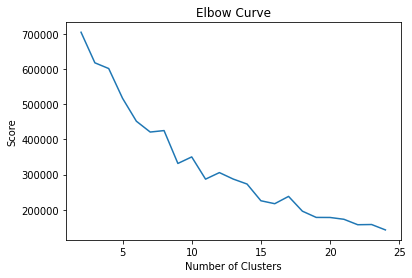

In [ ]:
import pandas as pd
cost = np.zeros(25)

for k in range(2,25):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('pca_features')
    model = kmeans.fit(dados_valor_pca)
    cost[k] = model.summary.trainingCost

# Plot the cost
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = list(range(2,25))
df_cost.insert(0, 'cluster', new_col)


import pylab as pl
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

A elbow-curve tem uma estrutura um pouco estranha mas podemos availiar que o melhor numero de cluster e 18

In [ ]:
SEED = 1334

In [ ]:
kmeans = KMeans(featuresCol = 'pca_features',predictionCol = 'cluster_pca').setK(18).setSeed(SEED)

In [ ]:
model_kmeans = kmeans.fit(dados_valor_pca)

In [ ]:
predictions_kmeans = model_kmeans.transform(dados_valor_pca)

In [ ]:
predictions_kmeans.show()

+--------------------+---------+--------------------+--------------------+-----------+
|            features|    valor|     scaled_features|        pca_features|cluster_pca|
+--------------------+---------+--------------------+--------------------+-----------+
|[8.0,115.0,3.0,4....| 750000.0|[0.49252751454913...|[6.81179811096317...|          8|
|(22,[1,2,3,4,5,6,...|2293758.0|(22,[1,2,3,4,5,6,...|[3.63621128401911...|         14|
|[6.0,89.0,3.0,3.0...|1065950.0|[0.36939563591185...|[6.50129756564094...|          8|
|(22,[1,2,3,4,5,6,...|1680000.0|(22,[1,2,3,4,5,6,...|[1.45744737144754...|         14|
|[3.0,315.0,3.0,4....|1999000.0|[0.18469781795592...|[7.55658550254306...|          6|
|(22,[1,2,3,5,6,7,...| 320000.0|(22,[1,2,3,5,6,7,...|[1.74783199923713...|          0|
|(22,[1,2,3,6,7,11...| 548210.0|(22,[1,2,3,6,7,11...|[0.41211542688100...|         14|
|[6.0,70.0,2.0,2.0...| 630000.0|[0.36939563591185...|[6.54891313206318...|         13|
|[3.0,90.0,1.0,3.0...|1007000.0|[0.18469781

## **Criando uma pipeline de KMeans**

In [ ]:
from pyspark.ml import Pipeline

In [ ]:
from pyspark.ml.functions import vector_to_array

In [ ]:
def pipeline_kmeans(data = dados, inputcols = X, k_PCA = 9 ,SEED = 1334, k_means = 16, ev = 'valor'):
  pca_pipeline_kmeans = Pipeline(stages = [ VectorAssembler(inputCols = inputcols, outputCol = 'features'), 
                                    StandardScaler(inputCol = 'features', outputCol = 'scaled_features'),
                                  PCA(k = k_PCA, inputCol = 'scaled_features', outputCol = 'pca_features'),
                                    KMeans(featuresCol = 'pca_features',predictionCol = 'cluster_pca').setK(k_means).setSeed(SEED)])
  pca_pipeline_model_kmeans = pca_pipeline_kmeans.fit(data) 
  dados_valor_pca_kmeans  = pca_pipeline_model_kmeans.transform(data)

  pca_features_xy = dados_valor_pca_kmeans.withColumn('x',vector_to_array('pca_features')[0])\
  .withColumn('y',vector_to_array('pca_features')[1])\
  .select(['x','y','cluster_pca',ev])

  fig = px.scatter(pca_features_xy.toPandas(), x = 'x', y = 'y', color = "cluster_pca", hover_data = ['x','y',ev])
  fig.show()
  return dados_valor_pca_kmeans

In [ ]:
predictions_kmean_pipeline = pipeline_kmeans()
predictions_kmean_pipeline.show(5, truncate = False)

+------------------------------------+-----+---------+---------+-------+------+----+----------+------+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+
|id                                  |andar|are

## **Filtrar imóveis do mesmo cluster**

Com os clusters prontos, podemos criar um filtro para extrair as informações de ID de um imóvel e verificar quais imóveis pertencem ao mesmo cluster.

In [ ]:
id_cluster_10 = predictions_kmean_pipeline.filter(predictions_kmean_pipeline.cluster_pca == 10).select('id').collect()[0][0]
id_cluster_10

'4655a90b-c6d3-4da2-b781-4d1f6335ae1a'

In [ ]:
id_imovel = "4655a90b-c6d3-4da2-b781-4d1f6335ae1a"

In [ ]:
cluster = predictions_kmean_pipeline.filter(predictions_kmean_pipeline.id == id_imovel).select('cluster_pca').collect()[0][0]
cluster

10

In [ ]:
imoveis_recomendados = predictions_kmean_pipeline.filter(predictions_kmean_pipeline['cluster_pca'] == cluster)\
                      .select('valor','id','pca_features')

imoveis_recomendados.show(5, truncate = False)

+--------+------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|valor   |id                                  |pca_features                                                                                                                                                                    |
+--------+------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|107000.0|4655a90b-c6d3-4da2-b781-4d1f6335ae1a|[1.4987174770357798,-1.148592584584585,2.0781218193020283,0.5038569284086842,-0.07591309305659635,0.2382447394857713,5.453607043293064,-4.833314163873731,0.07202177918284214]  |
|560000.0|d8c93260-4234-457f-8902-fc20a7198688|[3.4616828050840365,-1.5956402925906699,2.37872301068

# Sistema de recomendacao baseada na distancia eucludiana dos clusters

In [ ]:
from scipy.spatial.distance import euclidean
from pyspark.sql.types import FloatType

In [ ]:
  componentes_imovel = imoveis_recomendados.filter(imoveis_recomendados.id == '4655a90b-c6d3-4da2-b781-4d1f6335ae1a')\
                      .select('pca_features').collect()[0][0]
  componentes_imovel

DenseVector([1.4987, -1.1486, 2.0781, 0.5039, -0.0759, 0.2382, 5.4536, -4.8333, 0.072])

In [ ]:
def calcula_distancia(value):
  #componentes_imovel = imoveis_recomendados.filter(imoveis_recomendados.id == id_im)\
  #                    .select('pca_features').collect()[0][0]
  return euclidean(componentes_imovel, value)

udf_calcula_distancia = f.udf(calcula_distancia, FloatType())

In [ ]:
imoveis_recomendados_dist = imoveis_recomendados.withColumn('dist', udf_calcula_distancia('pca_features'))

recomendados = sessao_spark.createDataFrame(imoveis_recomendados_dist.sort('dist').take(10)).select('valor','id','dist')
recomendados.show()

+--------+--------------------+--------------------+
|   valor|                  id|                dist|
+--------+--------------------+--------------------+
|107000.0|4655a90b-c6d3-4da...|                 0.0|
|110000.0|341e5c4b-4323-49d...|0.010918513871729374|
|150000.0|b62fdf55-76d1-48a...|0.027300845831632614|
|165000.0|915277d1-c3db-4cd...|  0.0382130891084671|
|265000.0|f028dc22-cf05-42b...|0.038236986845731735|
|170000.0|4db4dd94-077f-4e9...| 0.04915150627493858|
|180000.0|03c0f48d-1b7a-486...| 0.05462216958403587|
|260000.0|979a4ac7-02b2-449...| 0.05464427173137665|
|250000.0|06fc83d3-92e1-45e...| 0.06550787389278412|
|175000.0|c952cb4a-3e45-499...| 0.06553176790475845|
+--------+--------------------+--------------------+



In [ ]:
def encontra_imovel(id_imovel):
  if len(predictions_kmean_pipeline.filter(predictions_kmean_pipeline.id == id_imovel).select('id').collect()) == 0:
    return True
  else:
    return False

def calcula_distancia(value):
  return euclidean(componentes_imovel, value)

udf_calcula_distancia = f.udf(calcula_distancia, FloatType())

def recomendador(id_imovel):
  # Calcula imoveis recomendados
  if encontra_imovel(id_imovel):
    return 'Imovel nao consta na base de dados'
  else:
    cluster = predictions_kmean_pipeline.filter(predictions_kmean_pipeline.id == id_imovel).select('cluster_pca').collect()[0][0]
    imoveis_recomendados = predictions_kmean_pipeline.filter(predictions_kmean_pipeline['cluster_pca'] == cluster)\
                        .select('*')
    componentes_imovel = imoveis_recomendados.filter(imoveis_recomendados.id == id_imovel)\
                        .select('pca_features').collect()[0][0]
    udf_calcula_distancia = f.udf(calcula_distancia, FloatType())
    imoveis_recomendados_dist = imoveis_recomendados.withColumn('dist', udf_calcula_distancia('pca_features'))
    recomendados = sessao_spark.createDataFrame(imoveis_recomendados_dist.sort('dist').take(10)).select('*')
  return recomendados

In [ ]:
recomendador(id_imovel).toPandas()

,id,andar,area_util,banheiros,quartos,suites,vaga,condominio,iptu,valor,...,Piscina,Playground,Portaria 24h,Portão eletrônico,Salão de festas,features,scaled_features,pca_features,cluster_pca,dist
0,4655a90b-c6d3-4da2-b781-4d1f6335ae1a,0,18.0,1,1,0,0,475.0,0.0,107000.0,...,0,0,0,0,0,"(0.0, 18.0, 1.0, 1.0, 0.0, 0.0, 475.0, 0.0, 1....","(0.0, 0.2000031790512021, 0.7384188316519307, ...","[1.4987174770357798, -1.148592584584585, 2.078...",10,0.000000
1,341e5c4b-4323-49d6-ac4b-47fb1acfad9a,0,20.0,1,1,0,0,457.0,0.0,110000.0,...,0,0,0,0,0,"(0.0, 20.0, 1.0, 1.0, 0.0, 0.0, 457.0, 0.0, 1....","(0.0, 0.22222575450133566, 0.7384188316519307,...","[1.5011454037722565, -1.139399283187448, 2.082...",10,0.010919
2,b62fdf55-76d1-48a4-82d0-05d3b60e9215,0,23.0,1,1,0,0,450.0,0.0,150000.0,...,0,0,0,0,0,"(0.0, 23.0, 1.0, 1.0, 0.0, 0.0, 450.0, 0.0, 1....","(0.0, 0.255559617676536, 0.7384188316519307, 1...","[1.504789049017627, -1.1256054394257888, 2.089...",10,0.027301
3,915277d1-c3db-4cd3-8180-0677a1ddedd1,0,25.0,1,1,0,0,403.0,0.0,165000.0,...,0,0,0,0,0,"(0.0, 25.0, 1.0, 1.0, 0.0, 0.0, 403.0, 0.0, 1....","(0.0, 0.2777821931266696, 0.7384188316519307, ...","[1.5072144308001525, -1.1164177809442841, 2.09...",10,0.038213
4,f028dc22-cf05-42b8-b9f9-180256ff9a69,0,25.0,1,1,0,0,491.0,0.0,265000.0,...,0,0,0,0,0,"(0.0, 25.0, 1.0, 1.0, 0.0, 0.0, 491.0, 0.0, 1....","(0.0, 0.2777821931266696, 0.7384188316519307, ...","[1.5072221534190386, -1.1164006576140897, 2.09...",10,0.038237
5,4db4dd94-077f-4e9f-a328-55d40e98800b,0,27.0,1,1,0,0,465.0,0.0,170000.0,...,0,0,0,0,0,"(0.0, 27.0, 1.0, 1.0, 0.0, 0.0, 465.0, 0.0, 1....","(0.0, 0.30000476857680314, 0.7384188316519307,...","[1.5096493780992526, -1.107208912883334, 2.099...",10,0.049152
6,03c0f48d-1b7a-486b-ae91-5c0b89e5bb07,0,28.0,1,1,0,0,492.0,0.0,180000.0,...,0,0,0,0,0,"(0.0, 28.0, 1.0, 1.0, 0.0, 0.0, 492.0, 0.0, 1....","(0.0, 0.31111605630186995, 0.7384188316519307,...","[1.5108665007206719, -1.1026052571860494, 2.10...",10,0.054622
7,979a4ac7-02b2-4498-8cbd-e4d2fe9d08fb,0,28.0,1,1,0,0,548.0,0.0,260000.0,...,0,0,0,0,0,"(0.0, 28.0, 1.0, 1.0, 0.0, 0.0, 548.0, 0.0, 1....","(0.0, 0.31111605630186995, 0.7384188316519307,...","[1.5108714151145084, -1.1025943605213802, 2.10...",10,0.054644
8,06fc83d3-92e1-45e5-8422-3bdb5260290b,0,30.0,1,1,0,0,350.0,0.0,250000.0,...,0,0,0,0,0,"(0.0, 30.0, 1.0, 1.0, 0.0, 0.0, 350.0, 0.0, 1....","(0.0, 0.3333386317520035, 0.7384188316519307, ...","[1.513283545585081, -1.0934360841178226, 2.106...",10,0.065508
9,c952cb4a-3e45-4999-8f0e-082822643870,0,30.0,1,1,0,0,450.0,0.0,175000.0,...,0,0,0,0,0,"(0.0, 30.0, 1.0, 1.0, 0.0, 0.0, 450.0, 0.0, 1....","(0.0, 0.3333386317520035, 0.7384188316519307, ...","[1.5132923212883609, -1.0934166257880562, 2.10...",10,0.065532
